In [27]:
import torch
import transformers
from transformers import AutoModel, AutoTokenizer

In [ ]:
model = AutoModel.from_pretrained('')

In [24]:
config = {
    'lr' : 0.01,
    'dataset': 'openwebtext'
}

In [28]:
import wandb
wandb.init(project='nanogpt',name='test_wandb_001', config=config)

In [ ]:
import torch
import torch.nn as nn

def forward_hook(module, input, output):
    print(f"Inside {module.__class__.__name__}'s forward hook")
    print("Input:", input)
    print("Output:", output)

model = nn.Linear(10, 5)
hook = model.register_forward_hook(forward_hook)

input = torch.randn(1, 10)
output = model(input)

hook.remove()  # 移除hook

In [29]:
from torch.distributed import init_process_group, destroy_process_group

In [51]:
from model import GPT, GPTConfig
import numpy as np

In [49]:
default_config = GPTConfig()

In [53]:
np.log(default_config.vocab_size)

10.825839875788878

In [50]:
default_config

GPTConfig(block_size=1024, vocab_size=50304, n_layer=12, n_head=12, n_embd=768, dropout=0.0, bias=True)

In [59]:
model = GPT(config=default_config)

number of parameters: 123.69M


In [60]:
model

GPT(
  (transformer): ModuleDict(
    (wte): Embedding(50304, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.0, inplace=False)
    (h): ModuleList(
      (0-11): 12 x Block(
        (ln_1): LayerNorm()
        (attn): CausalSelfAttention(
          (c_attn): Linear(in_features=768, out_features=2304, bias=True)
          (c_proj): Linear(in_features=768, out_features=768, bias=True)
          (attn_dropout): Dropout(p=0.0, inplace=False)
          (resid_dropout): Dropout(p=0.0, inplace=False)
        )
        (ln_2): LayerNorm()
        (mlp): MLP(
          (c_fc): Linear(in_features=768, out_features=3072, bias=True)
          (gelu): GELU(approximate='none')
          (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm()
  )
  (lm_head): Linear(in_features=768, out_features=50304, bias=False)
)

In [42]:
init_process_group(backend="nccl")

ValueError: Error initializing torch.distributed using env:// rendezvous: environment variable RANK expected, but not set

In [51]:
from model import GPT, GPTConfig, LayerNorm
import torch.nn as nn

In [52]:
config = GPTConfig()
net = GPT(config)

number of parameters: 123.69M


In [ ]:
GPT.from_pretrained('gpt')

In [40]:
layernorm_weights = {}
linear_grad = {}
linear_grad_weight = {}
for name, module in net.named_modules():
    if(isinstance(module, LayerNorm)):
        layernorm_weights[name] = module.weight.data.mean().item()
    elif(isinstance(module, nn.Linear) or isinstance(module, nn.Embedding)):
        linear_grad[name] = module.weight.grad.norm(2).item()
        linear_grad_weight[name] = module.weight.grad.norm(2).item() * lr / module.weight.data.norm(2).item()
wandb.log({"layernorm_weights": layernorm_weights, "linear_grad": linear_grad, "linear_grad_weight": linear_grad_weight})

In [29]:
lin = nn.Linear(3,4)

In [30]:
import torch
output = lin(torch.randn(2,3))

In [31]:
output.sum().backward()

In [38]:
lin.weight.grad.norm(2).item()

2.1099815368652344

In [46]:
import os
import numpy as np
data_dir = './data/openwebtext'
batch_size = 8
block_size = 1024
device_type = "cuda"
device = "cuda:0"

def get_batch(split):
    # We recreate np.memmap every batch to avoid a memory leak, as per
    # https://stackoverflow.com/questions/45132940/numpy-memmap-memory-usage-want-to-iterate-once/61472122#61472122
    if split == 'train':
        data = np.memmap(os.path.join(data_dir, 'train.bin'), dtype=np.uint16, mode='r')
    else:
        data = np.memmap(os.path.join(data_dir, 'val.bin'), dtype=np.uint16, mode='r')
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([torch.from_numpy((data[i:i+block_size]).astype(np.int64)) for i in ix])
    y = torch.stack([torch.from_numpy((data[i+1:i+1+block_size]).astype(np.int64)) for i in ix])
    if device_type == 'cuda':
        # pin arrays x,y, which allows us to move them to GPU asynchronously (non_blocking=True)
        x, y = x.pin_memory().to(device, non_blocking=True), y.pin_memory().to(device, non_blocking=True)
    else:
        x, y = x.to(device), y.to(device)
    return x, y

In [75]:
x,y = get_batch('train')

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "0,1"

from transformers import AutoModelForCausalLM, AutoTokenizer
device = "cuda" # the device to load the model onto

model = AutoModelForCausalLM.from_pretrained(
    "Qwen/Qwen2-7B-Instruct",
    torch_dtype="auto",
    device_map="auto",
    cache_dir = './model',
    local_files_only = True
)
tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen2-7B-Instruct", cache_dir='./tokenizer', local_files_only = True)

/home/zhaozk6/miniconda3/envs/codes/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading checkpoint shards: 100%|██████████| 4/4 [00:03<00:00,  1.27it/s]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [22]:
from transformers.models.qwen2.modeling_qwen2 import Qwen2RMSNorm
import matplotlib.pyplot as plt
import numpy as np

In [57]:
res = []
legends = []
cnt = 0
for name, module in model.named_modules():

    if isinstance(module, Qwen2RMSNorm):
        if cnt>10:
            break
        legends.append(name)
        res.append(module.weight.data.tolist())
        cnt += 1
res = np.array(res)

In [113]:
for i in range(28):
    res1 = model.model.layers[i].input_layernorm.weight.data.max()
    res2 = model.model.layers[i].post_attention_layernorm.weight.data.max()
    print(f'layer{i}, {res1}, {res2}')

layer0, 0.52734375, 1.1484375
layer1, 2.375, 5.46875
layer2, 1.921875, 4.71875
layer3, 1.75, 0.453125
layer4, 3.921875, 5.0625
layer5, 2.484375, 9.125
layer6, 2.5625, 3.703125
layer7, 2.375, 2.28125
layer8, 2.84375, 2.46875
layer9, 2.703125, 3.546875
layer10, 1.9921875, 1.8125
layer11, 2.03125, 1.78125
layer12, 2.375, 1.859375
layer13, 3.046875, 2.40625
layer14, 3.21875, 2.484375
layer15, 2.3125, 2.203125
layer16, 3.125, 2.3125
layer17, 2.984375, 2.546875
layer18, 2.671875, 2.59375
layer19, 2.859375, 3.421875
layer20, 2.65625, 3.5625
layer21, 2.59375, 3.90625
layer22, 2.421875, 3.5625
layer23, 2.515625, 2.84375
layer24, 3.671875, 3.359375
layer25, 3.140625, 5.59375
layer26, 4.84375, 6.875
layer27, 8.125, 10.4375


In [82]:
for i in range(model.model.layers[3].post_attention_layernorm.weight.data.shape[0]):
    if model.model.layers[3].post_attention_layernorm.weight.data[i].item()>8:
        print(i)

2718


In [83]:
model.model.layers[3].post_attention_layernorm.weight.data[2718]

tensor(9.1875, device='cuda:0', dtype=torch.bfloat16)

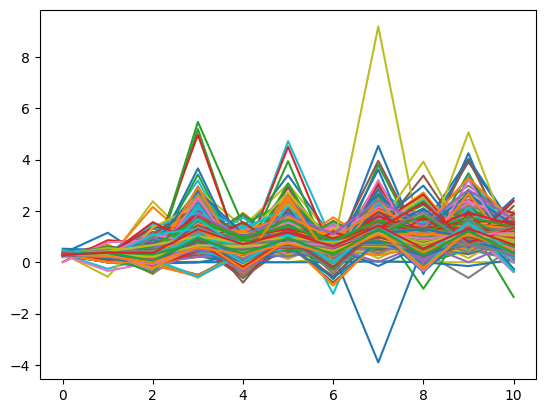

In [58]:
plt.plot(res);
# plt.legend(legends);

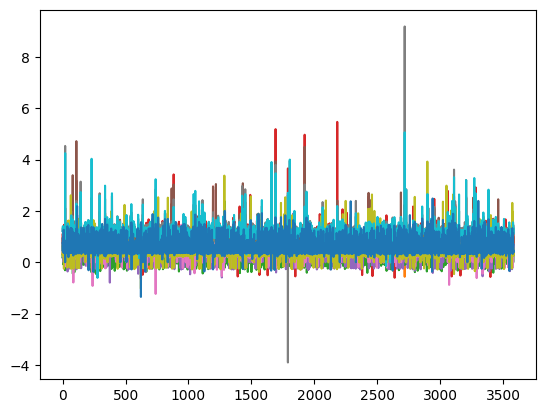

In [59]:
plt.plot(res.T);
# plt.legend(legends);

In [119]:
i = 7
model.model.layers[i].post_attention_layernorm.weight.requires_grad = False
# model.model.layers[3].post_attention_layernorm.weight.data[2718] *= 0.1
model.model.layers[i].post_attention_layernorm.weight *= 0.1

In [120]:
device = "cuda"
prompt = "Give me a short introduction to large language model."
# prompt = "what is one plus one?"

messages = [
    {"role": "system", "content": "You are a helpful assistant."},
    {"role": "user", "content": prompt}
]
text = tokenizer.apply_chat_template(
    messages,
    tokenize=False,
    add_generation_prompt=True
)
model_inputs = tokenizer([text], return_tensors="pt").to(device)

In [124]:
generated_ids = model.generate(
    model_inputs.input_ids,
    max_new_tokens=512
)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


In [122]:
generated_ids = [
    output_ids[len(input_ids):] for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)
]

response = tokenizer.batch_decode(generated_ids, skip_special_tokens=False)[0]

In [123]:
print(response)

Large language models, particularly those based on transformer architecture, are a type of deep learning models that operate on multiple levels of abstraction. They can be categorized into three main types:

1. **Masking Models**: These models learn to map input words to output words. They focus on the task level and are used for NLP tasks like question answering, text generation, and translation.

2. **Abstract-Comprehension Models**: These models aim to understand the meaning and context of sentences and paragraphs. They work at a higher level of language abstraction compared to word-level operations and are used for tasks such as summarization, and information extraction.

3. **End-to-End Reading Models**: For devices like reading comprehension and question answering, these models operate end-to-end, integrating with other components of a large language system to enable tasks that go beyond basic word-based operations.

These models, including BERT, Reformer, and Distil, are designe

In [2]:
from datasets import load_dataset
dataset = load_dataset('text', data_files='/home/zhaozk6/openwebtext/*.xz', split='train')

/home/zhaozk6/miniconda3/envs/codes/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [63]:
def remove_empty_strings(example):
    # 检查是否存在空字符串
    if example['text']=='' or '\x00\x00' in example['text']:
        return False  # 返回 None 表示过滤掉该行
    return True

# 应用处理函数，并过滤数据集
processed_dataset = dataset.filter(remove_empty_strings)

# owt by default only contains the 'train' split, so create a test split
split_dataset = dataset.train_test_split(test_size=0.0005, seed=2357, shuffle=True)

{'text': ''}

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "0,1"

from model import GPT

model = GPT.from_pretrained("gpt2", cache_dir='./model')

device = "cuda" # the device to load the model onto

/home/zhaozk6/miniconda3/envs/codes/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


loading weights from pretrained gpt: gpt2
forcing vocab_size=50257, block_size=1024, bias=True
number of parameters: 123.65M


In [68]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")

In [2]:
model

GPT(
  (transformer): ModuleDict(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.0, inplace=False)
    (h): ModuleList(
      (0-11): 12 x Block(
        (ln_1): LayerNorm()
        (attn): CausalSelfAttention(
          (c_attn): Linear(in_features=768, out_features=2304, bias=True)
          (c_proj): Linear(in_features=768, out_features=768, bias=True)
          (attn_dropout): Dropout(p=0.0, inplace=False)
          (resid_dropout): Dropout(p=0.0, inplace=False)
        )
        (ln_2): LayerNorm()
        (mlp): MLP(
          (c_fc): Linear(in_features=768, out_features=3072, bias=True)
          (gelu): GELU(approximate='none')
          (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm()
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [19]:
from model import LayerNorm
import torch
import numpy as np
import matplotlib.pyplot as plt
res = []
legends = []
cnt = 0
for name, module in model.named_modules():
    # print(module.__class__)
    if isinstance(module, torch.nn.Embedding) or isinstance(module, torch.nn.Linear):
        print(f"{name}: {module.weight.mean().item():.4f}, {module.weight.std().item():.4f}, {module.weight.norm(2).item():.4f} ")
    if isinstance(module, LayerNorm):
        # print(name, module.weight.shape)
        res.append(module.weight.data.tolist())
        legends.append(name)
res = np.array(res)

transformer.wte: 0.0004, 0.1437, 890.4819 
transformer.wpe: -0.0007, 0.1227, 108.7929 
transformer.h.0.attn.c_attn: 0.0001, 0.1996, 265.4996 
transformer.h.0.attn.c_proj: -0.0002, 0.1475, 113.2474 
transformer.h.0.mlp.c_fc: -0.0007, 0.1412, 216.8268 
transformer.h.0.mlp.c_proj: 0.0000, 0.0880, 135.1082 
transformer.h.1.attn.c_attn: 0.0000, 0.1401, 186.2990 
transformer.h.1.attn.c_proj: -0.0001, 0.1019, 78.2722 
transformer.h.1.mlp.c_fc: 0.0006, 0.1307, 200.7783 
transformer.h.1.mlp.c_proj: 0.0001, 0.0872, 133.9187 
transformer.h.2.attn.c_attn: 0.0001, 0.1527, 203.0690 
transformer.h.2.attn.c_proj: -0.0000, 0.0810, 62.2349 
transformer.h.2.mlp.c_fc: -0.0051, 0.1335, 205.2361 
transformer.h.2.mlp.c_proj: 0.0002, 0.0931, 142.9758 
transformer.h.3.attn.c_attn: -0.0000, 0.1418, 188.6252 
transformer.h.3.attn.c_proj: 0.0000, 0.0841, 64.6076 
transformer.h.3.mlp.c_fc: -0.0060, 0.1295, 199.1593 
transformer.h.3.mlp.c_proj: 0.0002, 0.0918, 141.0076 
transformer.h.4.attn.c_attn: 0.0002, 0.1464, 

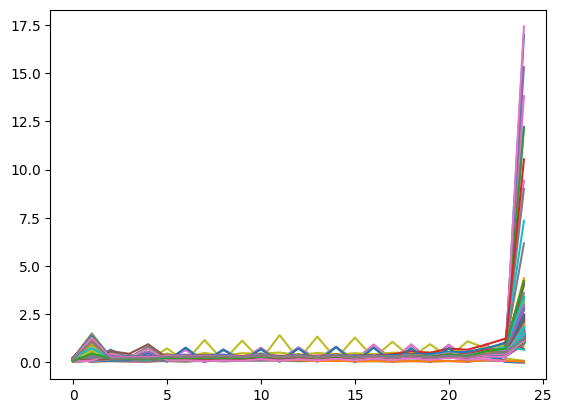

In [21]:
plt.plot(res);

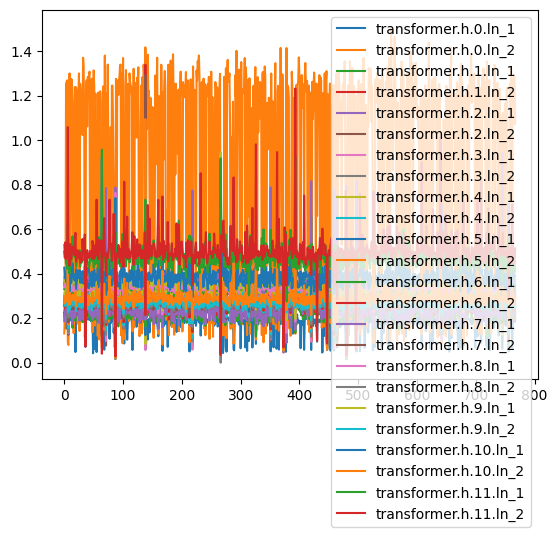

In [26]:
plt.plot(res[:-1,:].T);
plt.legend(legends)

In [36]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='0,1,2,3'
checkpoint = torch.load('./out/ckpt.pt', map_location="cuda:1")
checkpoint_model_args = checkpoint['model_args']

In [38]:
checkpoint['iter_num']

46000

In [2]:
model.config

NameError: name 'model' is not defined

In [3]:
def get_lr(it):
    # 1) linear warmup for warmup_iters steps
    if it < warmup_iters:
        return learning_rate * it / warmup_iters
    # 2) if it > lr_decay_iters, return min learning rate
    if it > lr_decay_iters:
        return min_lr
    # 3) in between, use cosine decay down to min learning rate
    decay_ratio = (it - warmup_iters) / (lr_decay_iters - warmup_iters)
    assert 0 <= decay_ratio <= 1
    coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio)) # coeff ranges 0..1
    return min_lr + coeff * (learning_rate - min_lr)